## Imports and setups

In [ ]:
import os
import random
import torch
from pathlib import Path
import numpy as np
from copy import deepcopy
from pprint import pprint as print

from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
from dataclasses import dataclass
from typing import List, Literal, Optional, Tuple
from torch.utils.data.dataloader import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from effdet import create_model, create_loader
from effdet.data import resolve_input_config, resolve_fill_color
from effdet.bench import DetBenchPredict  # noqa F401
from effdet.data.transforms import ResizePad, ImageToNumpy, Compose
from timm.optim._optim_factory import create_optimizer_v2

from ml_carbucks.utils.preprocessing import create_clean_loader, create_transforms, preprocess_images
from ml_carbucks.utils.inference import plot_img_pred_subplots as psp
from ml_carbucks import DATA_DIR, RESULTS_DIR
from ml_carbucks.utils.postprocessing import (
    postprocess_prediction_nms,
    postprocess_evaluation_results,
)
from ml_carbucks.utils.result_saver import ResultSaver
from ml_carbucks.adapters.BaseDetectionAdapter import (
    ADAPTER_METRICS,
    BaseDetectionAdapter,
    ADAPTER_PREDICTION,
)
from ml_carbucks.patches.effdet import (
    CocoStatsEvaluator,
    ConcatDetectionDataset,
    create_dataset_custom,
)
from ml_carbucks.utils.conversions import convert_yolo_to_coco
from ml_carbucks.utils.logger import setup_logger


logger = setup_logger(__name__)


DATASET_TUPLE_TYPE = tuple[str | Path, str | Path]

classes = ["scratch", "dent", "crack"]

cardd_dataset_train: DATASET_TUPLE_TYPE = (
    DATA_DIR / "car_dd" / "images" / "train",
    DATA_DIR / "car_dd" / "annotations" /"instances_train_curated.json",
)
cardd_dataset_val: DATASET_TUPLE_TYPE = (
    DATA_DIR / "car_dd" / "images" / "val",
    DATA_DIR / "car_dd" / "annotations" /"instances_val_curated.json",
)

carbucks_raw_dataset_train: DATASET_TUPLE_TYPE = (
    DATA_DIR / "carbucks" / "images" / "train",
    DATA_DIR / "carbucks" / "instances_train_curated.json",
)
carbucks_raw_dataset_val: DATASET_TUPLE_TYPE = (
    DATA_DIR / "carbucks" / "images" / "val",
    DATA_DIR / "carbucks" / "instances_val_curated.json",
)
carbucks_clean_dataset_train: DATASET_TUPLE_TYPE = (
    DATA_DIR / "carbucks_cleaned" / "images" / "train",
    DATA_DIR / "carbucks_cleaned" / "instances_train_curated.json",
)
carbucks_clean_dataset_val: DATASET_TUPLE_TYPE = (
    DATA_DIR / "carbucks_cleaned" / "images" / "val",
    DATA_DIR / "carbucks_cleaned" / "instances_val_curated.json",
)
carbucks_balanced_dataset_train : DATASET_TUPLE_TYPE = (
    DATA_DIR / "carbucks_balanced" / "images" / "train",
    DATA_DIR / "carbucks_balanced" / "instances_train_curated.json",
)
carbucks_balanced_dataset_val : DATASET_TUPLE_TYPE = (
    DATA_DIR / "carbucks_balanced" / "images" / "val",
    DATA_DIR / "carbucks_balanced" / "instances_val_curated.json",
)

mvp = {}


# Carbucks intial exploration 

## Displaying of carbucks dataset (sample) with its annotations
At the time of compute, the EXIF orientation tag was already fixed and re-saved.
The issue was that some images had EXIF orientation tag that made them appear rotated (correctly) in some viewers. And thus annotations seemed okay. However, when reading images with libraries that do not respect EXIF orientation tag (like OpenCV), the images appeared rotated incorrectly with respect to annotations.

In [6]:
def display_sample_batches(datasets: list[DATASET_TUPLE_TYPE], cnt: int | None = None, skip: int | None = None, batch_size: int | None = None, exif_aware: bool = False):
    loader = create_clean_loader(
        datasets=datasets,
        batch_size=batch_size if batch_size is not None else random.randint(4,8),
        shuffle=False,
        transforms=None,
        exif_aware=exif_aware
    )
    if cnt is None:
        cnt = random.randint(3,8)
    
    if skip is None:
        skip = random.randint(0,20)

    print(f"Showing {cnt} batches after skipping {skip} batches from loader with batch size {loader.batch_size}")
    for i, (imgs, targets) in enumerate(loader):
        if i < skip:
            continue
        if i >= cnt + skip:
            break

        print(f"Image batch {i}")
        img_tensors = [torch.from_numpy(img).permute(2, 0, 1) for img in imgs]
        psp(
            img_list=img_tensors,
            bboxes_list=[t["boxes"] for t in targets],
            labels_list=[t["labels"] for t in targets],
            coords="xyxy",
            figsize=(10, 15)
        )


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
'Showing 1 batches after skipping 6 batches from loader with batch size 10'


'Image batch 6'


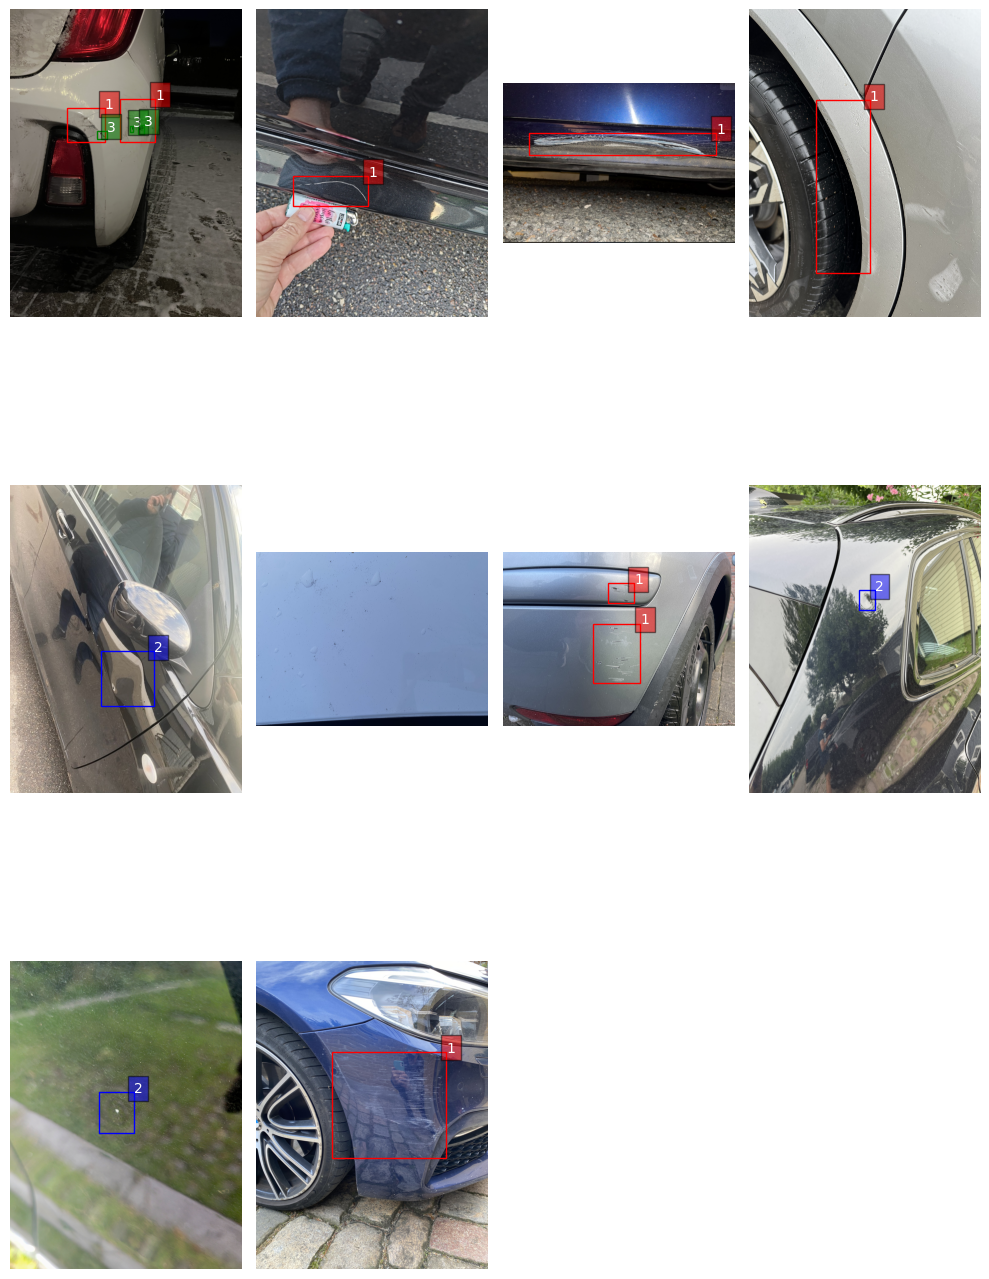

In [8]:
display_sample_batches(datasets=[carbucks_raw_dataset_train], cnt=1, skip=6, batch_size=10, exif_aware=False)

## Make analysis on datasets

In [6]:
def create_counter(images_dir_root: str | Path, splits: list = ["train", "val"], normalize: bool = False):
    counter = {"all": {}, "img_counts": {}}
    for split in splits:
        # load each file and count how many classes there are in each split and what is their distribution
        split_dir = os.path.join(images_dir_root, split)
        counter[split] = {}
        for root, dirs, files in os.walk(split_dir):
            for file in files:
                if not file.endswith(".jpg"):
                    continue

                file_path = os.path.join(root, file)
                label_path = file_path.replace("images", "labels").replace(".jpg", ".txt")

                counter["img_counts"][split] = counter["img_counts"].get(split, 0) + 1
                counter["img_counts"]['all'] = counter["img_counts"].get('all', 0) + 1
                if not os.path.exists(label_path):
                    counter['all']['no_label'] = counter['all'].get("no_label", 0) + 1
                    counter[split]["no_label"] = counter[split].get("no_label", 0) + 1
                    continue

                with open(label_path, "r") as f:
                    if len(f.read().strip()) == 0:
                        counter['all']['no_label'] = counter['all'].get("no_label", 0) + 1
                        counter[split]["no_label"] = counter[split].get("no_label", 0) + 1
                        continue
                    f.seek(0)
                    for line in f:
                        class_id = line.strip().split()[0]
                        counter[split][class_id] = counter[split].get(class_id, 0) + 1
                        counter['all'][class_id] = counter['all'].get(class_id, 0) + 1

    if normalize:
        counter_normalized = deepcopy(counter)
        for split in splits + ['all']:
            total = sum(counter_normalized[split].values())
            for class_id in counter_normalized[split]:
                counter_normalized[split][class_id] = round(counter_normalized[split][class_id] / total * 100, 4) 

            counter_normalized[split] = dict(sorted(counter_normalized[split].items(), key=lambda item: (item[0] != "no_label", int(item[0]) if item[0] != "no_label" else -1)))
        return counter_normalized
    else:
        for split in splits + ['all']:
            counter[split] = dict(sorted(counter[split].items(), key=lambda item: (item[0] != "no_label", int(item[0]) if item[0] != "no_label" else -1)))
    return counter

def visualize_counter(counter:dict, split: str = 'all', counter_name: str = ""):
    plt.bar(
        x=list(counter[split].keys()),
        height=[v for v in counter[split].values()]
    )
    plt.xlabel("Class ID")
    plt.ylabel("Proportion")
    # write actual numbers on top of bars
    for i, v in enumerate(counter[split].values()):
        plt.text(i, v + 0.5, str(v), ha='center')
    plt.title(f"Class Distribution in '{split}' Split for {counter_name} Dataset")
    plt.show()

def display_dataset_analysis(images_dir_root: str | Path, splits: list = ["train", "val"], counter_name: str = "", normalize: bool = False, visualize_splits: list = ['all']):
    counter = create_counter(images_dir_root, splits, normalize)
    print(f"Dataset Analysis for {counter_name} Dataset:")
    print(counter)
    for split in visualize_splits:
        visualize_counter(counter, split, counter_name)


'Dataset Analysis for Carbucks Dataset Dataset:'
{'all': {'0': 2817, '1': 826, '2': 414, 'no_label': 586},
 'img_counts': {'all': 2915, 'train': 2422, 'val': 493},
 'train': {'0': 2187, '1': 680, '2': 368, 'no_label': 485},
 'val': {'0': 630, '1': 146, '2': 46, 'no_label': 101}}


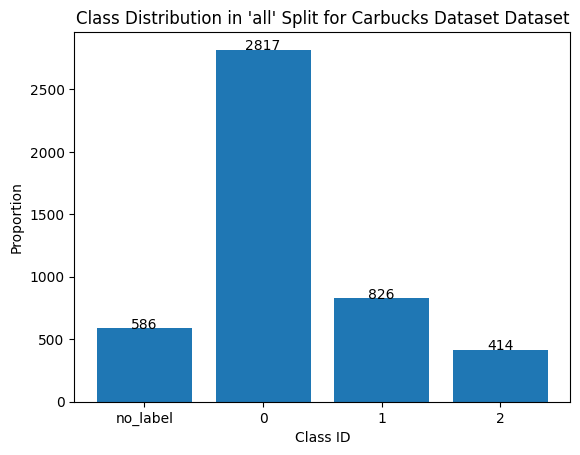

'Dataset Analysis for CardDD Dataset Dataset:'
{'all': {'0': 3288, '1': 2307, '2': 828, 'no_label': 809},
 'img_counts': {'all': 3626, 'train': 2816, 'val': 810},
 'train': {'0': 2560, '1': 1806, '2': 651, 'no_label': 632},
 'val': {'0': 728, '1': 501, '2': 177, 'no_label': 177}}


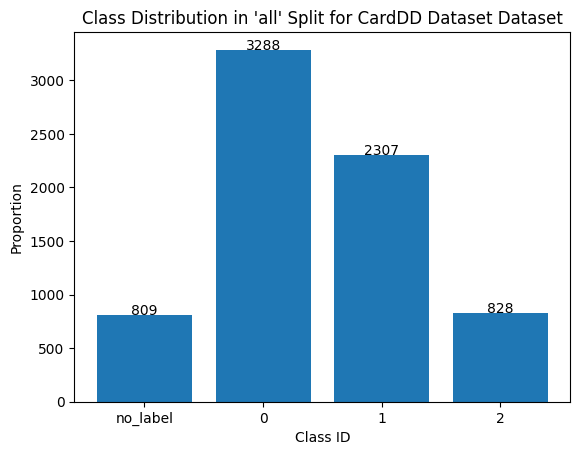

'Dataset Analysis for Carbucks Normalized Dataset Dataset:'
{'all': {'0': 60.672, '1': 17.7902, '2': 8.9166, 'no_label': 12.6212},
 'img_counts': {'all': 2915, 'train': 2422, 'val': 493},
 'train': {'0': 58.7903, '1': 18.2796, '2': 9.8925, 'no_label': 13.0376},
 'val': {'0': 68.2557, '1': 15.818, '2': 4.9837, 'no_label': 10.9426}}


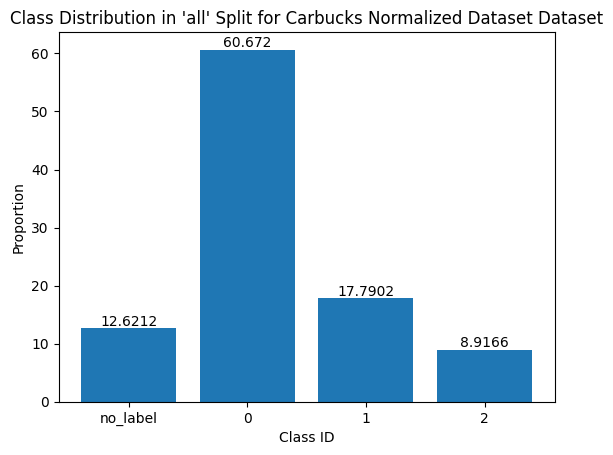

'Dataset Analysis for CardDD Normalized Dataset Dataset:'
{'all': {'0': 45.4646, '1': 31.8999, '2': 11.4491, 'no_label': 11.1864},
 'img_counts': {'all': 3626, 'train': 2816, 'val': 810},
 'train': {'0': 45.3178, '1': 31.9703, '2': 11.5242, 'no_label': 11.1878},
 'val': {'0': 45.9886, '1': 31.6488, '2': 11.1813, 'no_label': 11.1813}}


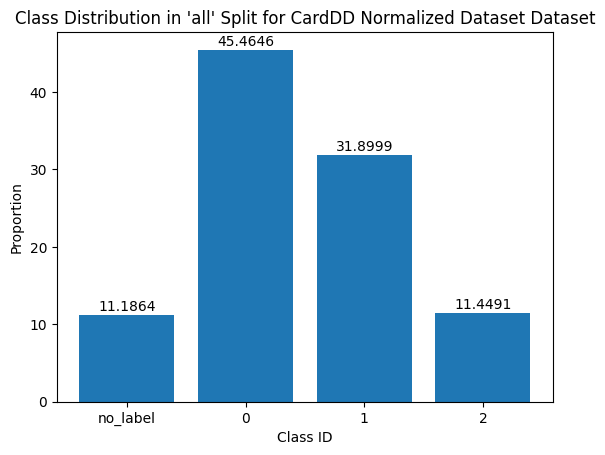

In [7]:
display_dataset_analysis(carbucks_raw_dataset_train[0].parent, counter_name="Carbucks Dataset") # type: ignore
display_dataset_analysis(cardd_dataset_train[0].parent, counter_name="CardDD Dataset") # type: ignore
display_dataset_analysis(carbucks_raw_dataset_train[0].parent, counter_name="Carbucks Normalized Dataset", normalize=True, visualize_splits=["all"]) # type: ignore
display_dataset_analysis(cardd_dataset_train[0].parent, counter_name="CardDD Normalized Dataset", normalize=True, visualize_splits=["all"]) # type: ignore

## Dataset manipulation : removing no_label images and balancing

Those **functions** might be potentially **destructive**, so make sure you know how to use them **Before** applying them to your dataset.

It will not delete those files but **move them** to an **"empty" folder** within the dataset directory.

In [16]:
def clean_up_empty_labels(dataset_dir: str | Path, splits: list):
    print(f"Cleaning up empty labels in dataset at: {dataset_dir}")
    for split in splits:
        for root, dirs, files in os.walk(Path(dataset_dir) / "images" / split):
            for file in files:
                if not file.endswith(".jpg"):
                    continue
                
                img_file_path = os.path.join(root, file)
                label_file_path = img_file_path.replace(".jpg", ".txt").replace("images", "labels")
                img_name = file
                label_name = img_name.replace(".jpg", ".txt")

                if not os.path.exists(label_file_path):
                    print(f"Found image with no corresponding label file: {img_file_path}")
                    os.makedirs(os.path.join(dataset_dir, "images", "empty", split), exist_ok=True)
                    # move image file
                    new_img_path = os.path.join(dataset_dir, "images", "empty", split, file)
                    os.rename(img_file_path, new_img_path)
                    continue

                with open(label_file_path, "r") as f:
                    lines = f.readlines()
                
                if len(lines) == 0:
                    print(f"Found empty label file: {label_file_path}")
                    os.makedirs(os.path.join(dataset_dir, "images", "empty", split), exist_ok=True)
                    os.makedirs(os.path.join(dataset_dir, "labels", "empty", split), exist_ok=True)
                    # move label file
                    new_label_path = os.path.join(dataset_dir, "labels", "empty", split, label_name)
                    os.rename(label_file_path, new_label_path)
                    # move image file
                    new_img_path = os.path.join(dataset_dir, "images", "empty", split, img_name)
                    os.rename(img_file_path, new_img_path)

    convert_yolo_to_coco(
        base_dir=dataset_dir,
        splits=splits,
    )
                    

def balance_dataset(dataset_dir: str | Path, splits: list, remove_class_probabilities: dict[str, float] | None = None):
    for split in splits:
        files_moved_cnt = {class_id: 0 for class_id in remove_class_probabilities.keys()} if remove_class_probabilities else {}
        for root, dirs, files in os.walk(Path(dataset_dir) / "labels" / split):
            for file in files:
                if not file.endswith(".txt"):
                    continue
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    lines = f.readlines()
                
                class_labels = set()
                for line in lines:
                    class_id = line.strip().split()[0]
                    class_labels.add(class_id)

                # we want to move the files only that have pure one class labels, not mixed
                if len(class_labels) != 1:
                    continue

                class_id = class_labels.pop()
                move_file = False
                if remove_class_probabilities and class_id in remove_class_probabilities:
                    prob = remove_class_probabilities[class_id]
                    if random.random() <= prob:
                        move_file = True

                if move_file:
                    files_moved_cnt[class_id] += 1
                    print(f"Moving pure class {class_id} label file: {file_path}")
                    os.makedirs(os.path.join(dataset_dir, "images", "balancing", split), exist_ok=True)
                    os.makedirs(os.path.join(dataset_dir, "labels", "balancing", split), exist_ok=True)
                    # move label file
                    new_label_path = os.path.join(dataset_dir, "labels", "balancing", split, file)
                    os.rename(file_path, new_label_path)
                    # move image file
                    img_file = file.replace(".txt", ".jpg")
                    img_path = os.path.join(dataset_dir, "images", split, img_file)
                    if os.path.exists(img_path):
                        new_img_path = os.path.join(dataset_dir, "images", "balancing", split, img_file)
                        os.rename(img_path, new_img_path)
                    else:
                        print(f"⚠️ Corresponding image file not found for label: {file_path}")
        if files_moved_cnt:
            print(f"Moved files for {split}: {files_moved_cnt}")


    convert_yolo_to_coco(
        base_dir=dataset_dir,
        splits=splits,
    )
       


('Cleaning up empty labels in dataset at: '
 '/home/bachelor/ml-carbucks/data/carbucks_cleaned')
Saved /home/bachelor/ml-carbucks/data/carbucks_cleaned/instances_train_curated.json with 1937 images and 3235 annotations.
Saved /home/bachelor/ml-carbucks/data/carbucks_cleaned/instances_val_curated.json with 392 images and 822 annotations.
'Dataset Analysis for Carbucks Cleaned Dataset Dataset:'
{'all': {'0': 69.4355, '1': 20.3599, '2': 10.2046},
 'img_counts': {'all': 2329, 'train': 1937, 'val': 392},
 'train': {'0': 67.6043, '1': 21.0201, '2': 11.3756},
 'val': {'0': 76.6423, '1': 17.7616, '2': 5.5961}}


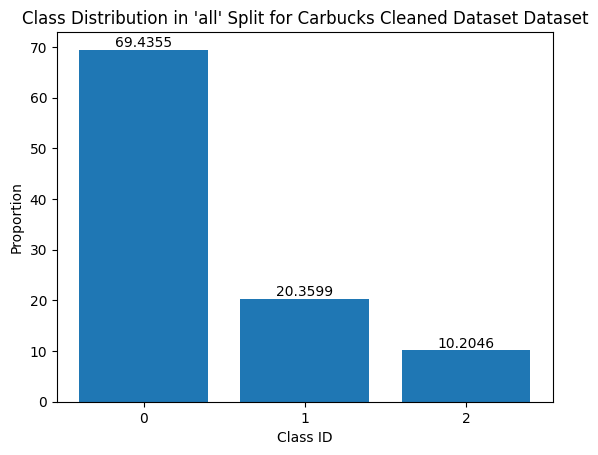

"Moved files for train: {'0': 0, '1': 0, '2': 0}"
"Moved files for val: {'0': 0, '1': 0, '2': 0}"
Saved /home/bachelor/ml-carbucks/data/carbucks_balanced/instances_train_curated.json with 1150 images and 2061 annotations.
Saved /home/bachelor/ml-carbucks/data/carbucks_balanced/instances_val_curated.json with 167 images and 380 annotations.
'Dataset Analysis for Carbucks Balanced Dataset Dataset:'
{'all': {'0': 49.2011, '1': 33.8386, '2': 16.9603},
 'img_counts': {'all': 1317, 'train': 1150, 'val': 167},
 'train': {'0': 49.1509, '1': 32.9937, '2': 17.8554},
 'val': {'0': 49.4737, '1': 38.4211, '2': 12.1053}}


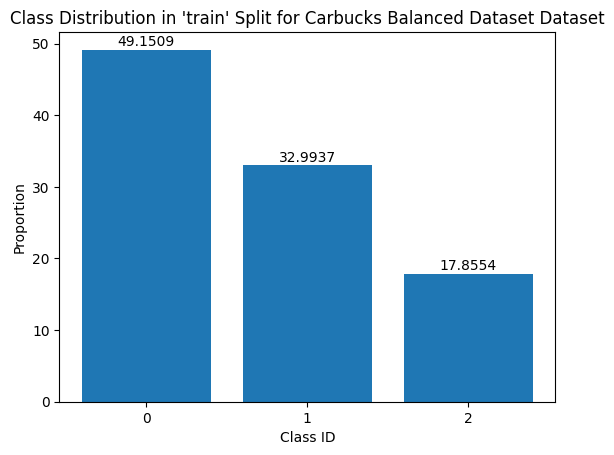

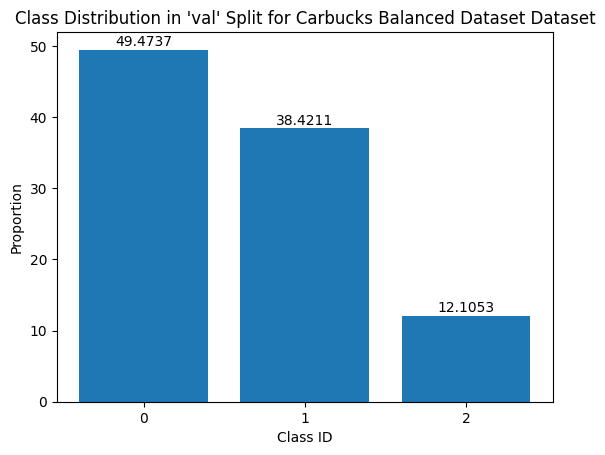

In [17]:
# NOTE: this function will remove "no annotations files" and move them to "empty" folder within the dataset
clean_up_empty_labels(carbucks_clean_dataset_train[0].parent.parent, splits=["train", "val"]) # type: ignore       

display_dataset_analysis(carbucks_clean_dataset_train[0].parent, counter_name="Carbucks Cleaned Dataset", normalize=True) # type: ignore


# NOTE: settings 0.0 will not remove any files, adjust as needed and move them to "balancing" folder
balance_dataset(
    dataset_dir=carbucks_balanced_dataset_train[0].parent.parent, # type: ignore
    splits=[], # <- adjust splits as needed ("train", "val" or both)
    remove_class_probabilities={
        "0": 0.0, # <- this can be adjusted to remove some, it removes the % of pure class images
        "1": 0.0, # <-
        "2": 0.0, # <-
    }
)

display_dataset_analysis(carbucks_balanced_dataset_train[0].parent, counter_name="Carbucks Balanced Dataset", normalize=True, visualize_splits=["train", "val"]) # type: ignore


# Carbucks secondary exploration

## Effdet with in-built loader

In [10]:
@dataclass
class EfficientDetAdapterInbuildLoader(BaseDetectionAdapter):

    weights: str | Path = ""
    backbone: str = "tf_efficientdet_d0"

    optimizer: str = "momentum"
    lr: float = 8e-3
    weight_decay: float = 9e-6
    confidence_threshold: float = 0.15
    training_augmentations: bool = True

    def save(self, dir: Path | str, prefix: str = "", suffix: str = "") -> Path:
        save_path = Path(dir) / f"{prefix}model{suffix}.pth"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.model.model.state_dict(), save_path)
        return save_path

    def _preprocess_images(
        self, images: List[np.ndarray]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input_config = resolve_input_config(self.get_params(), self.model.config)
        fill_color = resolve_fill_color(
            input_config["fill_color"], input_config["mean"]
        )

        mean = (
            torch.tensor(input_config["mean"], device=self.device).view(3, 1, 1) * 255
        )
        std = torch.tensor(input_config["std"], device=self.device).view(3, 1, 1) * 255

        transform = Compose(
            [
                ResizePad(
                    target_size=self.img_size,
                    interpolation=input_config["interpolation"],
                    fill_color=fill_color,
                ),
                ImageToNumpy(),
            ]
        )

        batch, scales = [], []

        for img in images:

            img_np, anno = transform(Image.fromarray(img), {})
            scales.append(anno.get("img_scale", 1.0))

            img_norm = (
                torch.from_numpy(img_np)
                .to(self.device, non_blocking=True)
                .float()
                .sub_(mean)
                .div_(std)
            )
            batch.append(img_norm)

        batch_tensor = torch.stack(batch, dim=0)  # B,C,H,W
        scales_tensor = torch.tensor(scales, dtype=torch.float32, device=self.device)
        batch_original_sizes = torch.tensor(
            [[img.shape[1], img.shape[0]] for img in images],
            dtype=torch.float32,
            device=self.device,
        )

        return batch_tensor, scales_tensor, batch_original_sizes

    def predict(
        self,
        images: List[np.ndarray],
        conf_threshold: float = 0.15,
        iou_threshold: float = 1.0,
        max_detections: int = 10,
    ) -> List[ADAPTER_PREDICTION]:
        """
        The issue is that predicitons are weird but the results of the evaluation
        are good. So either the evaluation is wrong or the prediction extraction is wrong.
        """
        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()
        predictions: List[ADAPTER_PREDICTION] = []

        with torch.no_grad():

            batch_tensor, batch_scales, batch_original_sizes = self._preprocess_images(
                images
            )

            # NOTE: Passing the img_info dict will allow to get the predictions in original image scale
            img_info_dict = {
                "img_scale": batch_scales,
                "img_size": batch_original_sizes,
            }

            outputs = predictor(batch_tensor, img_info=img_info_dict)

            for i, pred in enumerate(outputs):
                boxes = pred[:, :4]
                scores = pred[:, 4]
                labels_idx = pred[:, 5]

                prediction = postprocess_prediction_nms(
                    boxes,
                    scores,
                    labels_idx,
                    conf_threshold,
                    iou_threshold,
                    max_detections,
                )

                predictions.append(prediction)

        return predictions

    def setup(self) -> "EfficientDetAdapterInbuildLoader":
        img_size = self.img_size

        backbone = self.backbone
        weights = self.weights

        extra_args = dict(image_size=(img_size, img_size))
        self.model = create_model(
            model_name=backbone,
            bench_task="train",
            num_classes=len(self.classes),
            pretrained=weights == "",
            checkpoint_path=str(weights),
            # NOTE: we set it to True because we are using custom Mean Average Precision and it is easier that way
            # custom anchor labeler would be good idea if the boxes had unusual sizes and aspect ratios -> worth remembering for future
            bench_labeler=True,
            checkpoint_ema=False,
            **extra_args,
        )

        self.model.to(self.device)

        return self

    def fit(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> "EfficientDetAdapterInbuildLoader":
        logger.info("Starting training...")
        self.model.train()

        epochs = self.epochs
        opt = self.optimizer
        lr = self.lr
        weight_decay = self.weight_decay

        train_loader = self._create_loader(datasets, is_training=True)

        parser_max_label = train_loader.dataset.parsers[0].max_label  # type: ignore
        config_num_classes = self.model.config.num_classes

        if parser_max_label != config_num_classes:
            raise ValueError(
                f"Number of classes in dataset ({parser_max_label}) does not match "
                f"model config ({config_num_classes})."
                f"Please verify that the dataset is curated (classes IDs start from 1)"
            )

        optimizer = create_optimizer_v2(
            self.model,
            opt=opt,
            lr=lr,
            weight_decay=weight_decay,
        )

        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            _ = self.train_epoch(optimizer, train_loader)  # type: ignore

        return self

    def _create_loader(
        self, datasets: List[Tuple[str | Path, str | Path]], is_training: bool
    ):
        batch_size = self.batch_size

        all_datasets = []
        for img_dir, ann_file in datasets:
            dataset = create_dataset_custom(
                img_dir=img_dir,
                ann_file=ann_file,
                has_labels=True,
            )
            all_datasets.append(dataset)

        concat_dataset = ConcatDetectionDataset(all_datasets)

        if is_training and (not self.training_augmentations):
            logger.warning(
                "Data augmentations are disabled. This may worsen model performance. It should only be used for debugging purposes."
            )

        input_config = resolve_input_config(self.get_params(), self.model.config)
        loader = create_loader(
            concat_dataset,
            input_size=input_config["input_size"],
            batch_size=batch_size,
            is_training=is_training and self.training_augmentations,
            use_prefetcher=True,
            interpolation=input_config["interpolation"],
            fill_color=input_config["fill_color"],
            mean=input_config["mean"],
            std=input_config["std"],
            num_workers=4,
            distributed=False,
            pin_mem=False,
            anchor_labeler=None,
            transform_fn=None,
            collate_fn=None,
        )

        return loader

    def train_epoch(
        self, optimizer: torch.optim.Optimizer, loader: DataLoader
    ) -> float:
        self.model.train()

        total_loss = 0.0
        for imgs, targets in tqdm(loader):
            output = self.model(imgs, targets)
            loss = output["loss"]
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return total_loss

    def debug(
        self,
        train_datasets: List[Tuple[str | Path, str | Path]],
        val_datasets: List[Tuple[str | Path, str | Path]],
        results_path: str | Path,
        results_name: str,
        visualize: Literal["every", "last", "none"] = "none",
    ) -> ADAPTER_METRICS:
        logger.info("Debugging training and evaluation loops...")

        epochs = self.epochs
        train_loader = self._create_loader(train_datasets, is_training=True)
        optimizer = create_optimizer_v2(
            self.model,
            opt=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )
        saver = ResultSaver(
            path=results_path,
            name=results_name,
        )
        val_metrics: Optional[ADAPTER_METRICS] = None
        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            total_loss = self.train_epoch(optimizer, train_loader)  # type: ignore
            val_metrics = self.evaluate(val_datasets)
            saver.save(
                epoch=epoch,
                loss=total_loss,
                val_map=val_metrics["map_50_95"],
                val_map_50=val_metrics["map_50"],
            )
            logger.info(
                f"Debug Epoch {epoch}/{epochs} - Loss: {total_loss}, Val MAP: {val_metrics['map_50_95']}"
            )

            show = False
            if visualize == "every":
                show = True
            elif visualize == "last" and epoch == epochs:
                show = True
            saver.plot(show=show)

        if val_metrics is None:
            raise RuntimeError("Validation metrics were not computed during debugging.")
        return val_metrics

    def evaluate(
        self,
        datasets: List[Tuple[str | Path, str | Path]],
        include_default: bool = False,
    ) -> ADAPTER_METRICS:
        self.model.eval()

        val_loader = self._create_loader(datasets, is_training=False)

        default_evaluator = None
        if include_default:
            default_evaluator = CocoStatsEvaluator(dataset=val_loader.dataset)

        evaluator = MeanAveragePrecision(extended_summary=False, class_metrics=False)
        total_loss = 0.0

        with torch.no_grad():
            for imgs, targets in val_loader:
                output = self.model(imgs, targets)
                loss = output["loss"]
                total_loss += loss.item()

                if include_default and default_evaluator is not None:
                    default_evaluator.add_predictions(
                        detections=output["detections"], target=targets
                    )

                # NOTE:
                # Annotations are loaded in yxyx format and they are scaled
                # Predicitons are in xyxy format and not scaled (original size of the image)
                # So we need to rescale the ground truth boxes to original sizes
                # Predicitons have a lot of low confidence scores and ground_truths have a lot of -1 values that just indicate no object
                # We need to filter them out
                for i in range(len(imgs)):
                    scale = targets["img_scale"][i]

                    pred_mask = (
                        output["detections"][i][:, 4] >= self.confidence_threshold
                    )
                    if pred_mask.sum() == 0:
                        # No predcitions above the confidence threshold
                        pred_boxes = torch.zeros((0, 4), dtype=torch.float32)
                        pred_scores = torch.zeros((0,), dtype=torch.float32)
                        pred_labels = torch.zeros((0,), dtype=torch.int64)
                    else:
                        pred_boxes = output["detections"][i][pred_mask, :4]
                        pred_scores = output["detections"][i][pred_mask, 4]
                        pred_labels = output["detections"][i][pred_mask, 5].long()

                    gt_mask = targets["cls"][i] != -1
                    if gt_mask.sum() == 0:
                        # No ground truth boxes
                        gt_boxes = torch.zeros((0, 4), dtype=torch.float32)
                        gt_labels = torch.zeros((0,), dtype=torch.int64)
                    else:
                        gt_boxes_yxyx_raw = targets["bbox"][i][gt_mask]
                        gt_boxes_xyxy = torch.zeros_like(gt_boxes_yxyx_raw)
                        gt_boxes_xyxy[:, 0] = gt_boxes_yxyx_raw[:, 1]
                        gt_boxes_xyxy[:, 1] = gt_boxes_yxyx_raw[:, 0]
                        gt_boxes_xyxy[:, 2] = gt_boxes_yxyx_raw[:, 3]
                        gt_boxes_xyxy[:, 3] = gt_boxes_yxyx_raw[:, 2]
                        gt_boxes = gt_boxes_xyxy * scale
                        gt_labels = targets["cls"][i][gt_mask].long()

                    evaluator.update(
                        preds=[
                            {
                                "boxes": pred_boxes.cpu(),
                                "scores": pred_scores.cpu(),
                                "labels": pred_labels.cpu(),
                            }
                        ],
                        target=[
                            {
                                "boxes": gt_boxes.cpu(),
                                "labels": gt_labels.cpu(),
                            }
                        ],
                    )

        results = evaluator.compute()
        metrics = postprocess_evaluation_results(results)

        if include_default and default_evaluator is not None:
            default_results = default_evaluator.evaluate()
            metrics["default_map_50_95"] = default_results[0]  # type: ignore
            metrics["default_map_50"] = default_results[1]  # type: ignore

        return metrics



## Effdet with custom loader

In [11]:
@dataclass
class EfficientDetAdapterCustomLoader(BaseDetectionAdapter):

    weights: str | Path = ""
    backbone: str = "tf_efficientdet_d0"

    optimizer: str = "momentum"
    lr: float = 8e-3
    weight_decay: float = 9e-6
    confidence_threshold: float = 0.15
    training_augmentations: bool = True

    def save(self, dir: Path | str, prefix: str = "", suffix: str = "") -> Path:
        save_path = Path(dir) / f"{prefix}model{suffix}.pth"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.model.model.state_dict(), save_path)
        return save_path


    def predict(
        self,
        images: List[np.ndarray],
        conf_threshold: float = 0.15,
        iou_threshold: float = 1.0,
        max_detections: int = 10,
    ) -> List[ADAPTER_PREDICTION]:
        """
        The issue is that predicitons are weird but the results of the evaluation
        are good. So either the evaluation is wrong or the prediction extraction is wrong.
        """
        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()
        predictions: List[ADAPTER_PREDICTION] = []

        with torch.no_grad():

            preprocessed_images, scales, original_sizes = preprocess_images(
                images, img_size=self.img_size
            )

            batch_img_tensor = torch.stack(preprocessed_images).to(self.device)
            batch_scales = torch.tensor(scales, dtype=torch.float32, device=self.device)
            batch_original_sizes = torch.tensor(original_sizes, dtype=torch.float32, device=self.device)

            # NOTE: Passing the img_info dict will allow to get the predictions in original image scale
            img_info_dict = {
                "img_scale": batch_scales,
                "img_size": batch_original_sizes,
            }

            outputs = predictor(batch_img_tensor, img_info=img_info_dict)

            for i, pred in enumerate(outputs):
                boxes = pred[:, :4]
                scores = pred[:, 4]
                labels_idx = pred[:, 5]

                prediction = postprocess_prediction_nms(
                    boxes,
                    scores,
                    labels_idx,
                    conf_threshold,
                    iou_threshold,
                    max_detections,
                )

                predictions.append(prediction)

        return predictions

    def setup(self) -> "EfficientDetAdapterCustomLoader":
        img_size = self.img_size

        backbone = self.backbone
        weights = self.weights

        extra_args = dict(image_size=(img_size, img_size))
        self.model = create_model(
            model_name=backbone,
            bench_task="train",
            num_classes=len(self.classes),
            pretrained=weights == "",
            checkpoint_path=str(weights),
            # NOTE: we set it to True because we are using custom Mean Average Precision and it is easier that way
            # custom anchor labeler would be good idea if the boxes had unusual sizes and aspect ratios -> worth remembering for future
            bench_labeler=True,
            checkpoint_ema=False,
            **extra_args,
        )

        self.model.to(self.device)

        return self

    def fit(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> "EfficientDetAdapterCustomLoader":
        logger.info("Starting training...")
        self.model.train()

        epochs = self.epochs
        opt = self.optimizer
        lr = self.lr
        weight_decay = self.weight_decay

        train_loader = self._create_loader(datasets, is_training=True)

        parser_max_label = train_loader.dataset.parsers[0].max_label  # type: ignore
        config_num_classes = self.model.config.num_classes

        if parser_max_label != config_num_classes:
            raise ValueError(
                f"Number of classes in dataset ({parser_max_label}) does not match "
                f"model config ({config_num_classes})."
                f"Please verify that the dataset is curated (classes IDs start from 1)"
            )

        optimizer = create_optimizer_v2(
            self.model,
            opt=opt,
            lr=lr,
            weight_decay=weight_decay,
        )

        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            _ = self.train_epoch(optimizer, train_loader)  # type: ignore

        return self

    def _create_loader(
        self, datasets: List[Tuple[str | Path, str | Path]], is_training: bool
    ):
        batch_size = self.batch_size
        img_size = self.img_size
        loader = create_clean_loader(
            datasets,
            shuffle=is_training and self.training_augmentations,
            batch_size=batch_size,
            transforms=create_transforms(
                is_training=is_training and self.training_augmentations,
                img_size=img_size,
            ),
            format="yxyx",
            placeholders=100,
        )

        return loader

    def _convert_batch(
        self, imgs: List[torch.Tensor], targets: List[dict]
    ) -> Tuple[torch.Tensor, dict]:
        imgs = list(img.to(self.device) for img in imgs)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        imgs_tensor = torch.stack(imgs)
        targets_dict = {
            "bbox": torch.stack([t["boxes"] for t in targets]),
            "cls": torch.stack([t["labels"] for t in targets]),
            "img_size": torch.stack(
                [t["img_size"] for t in targets]),
            "img_scale": torch.stack(
                [t["img_scale"] for t in targets]),
        }
        return imgs_tensor, targets_dict

    def train_epoch(
        self, optimizer: torch.optim.Optimizer, loader: DataLoader
    ) -> float:
        self.model.train()

        total_loss = 0.0
        for imgs, targets in tqdm(loader):
            
            cimgs, ctargets = self._convert_batch(imgs, targets)
            output = self.model(cimgs, ctargets)
            loss = output["loss"]
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return total_loss

    def debug(
        self,
        train_datasets: List[Tuple[str | Path, str | Path]],
        val_datasets: List[Tuple[str | Path, str | Path]],
        results_path: str | Path,
        results_name: str,
        visualize: Literal["every", "last", "none"] = "none",
    ) -> ADAPTER_METRICS:
        logger.info("Debugging training and evaluation loops...")

        epochs = self.epochs
        train_loader = self._create_loader(train_datasets, is_training=True)
        optimizer = create_optimizer_v2(
            self.model,
            opt=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )
        saver = ResultSaver(
            path=results_path,
            name=results_name,
        )
        val_metrics: Optional[ADAPTER_METRICS] = None
        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            total_loss = self.train_epoch(optimizer, train_loader)  # type: ignore
            val_metrics = self.evaluate(val_datasets)
            saver.save(
                epoch=epoch,
                loss=total_loss,
                val_map=val_metrics["map_50_95"],
                val_map_50=val_metrics["map_50"],
            )
            logger.info(
                f"Debug Epoch {epoch}/{epochs} - Loss: {total_loss}, Val MAP: {val_metrics['map_50_95']}"
            )

            show = False
            if visualize == "every":
                show = True
            elif visualize == "last" and epoch == epochs:
                show = True
            saver.plot(show=show)

        if val_metrics is None:
            raise RuntimeError("Validation metrics were not computed during debugging.")
        return val_metrics

    def evaluate(
        self,
        datasets: List[Tuple[str | Path, str | Path]],
        include_default: bool = False,
    ) -> ADAPTER_METRICS:
        self.model.eval()

        val_loader = self._create_loader(datasets, is_training=False)

        default_evaluator = None
        if include_default:
            default_evaluator = CocoStatsEvaluator(dataset=val_loader.dataset)

        evaluator = MeanAveragePrecision(extended_summary=False, class_metrics=False)
        total_loss = 0.0

        with torch.no_grad():
            for imgs, targets in val_loader:
                cimgs, ctargets = self._convert_batch(imgs, targets)
                output = self.model(cimgs, ctargets)
                loss = output["loss"]
                total_loss += loss.item()

                if include_default and default_evaluator is not None:
                    default_evaluator.add_predictions(
                        detections=output["detections"], target=ctargets
                    )

                # NOTE:
                # Annotations are loaded in yxyx format and they are scaled
                # Predicitons are in xyxy format and not scaled (original size of the image)
                # So we need to rescale the ground truth boxes to original sizes
                # Predicitons have a lot of low confidence scores and ground_truths have a lot of -1 values that just indicate no object
                # We need to filter them out
                for i in range(len(cimgs)):
                    scale = ctargets["img_scale"][i]

                    pred_mask = (
                        output["detections"][i][:, 4] >= self.confidence_threshold
                    )
                    if pred_mask.sum() == 0:
                        # No predcitions above the confidence threshold
                        pred_boxes = torch.zeros((0, 4), dtype=torch.float32)
                        pred_scores = torch.zeros((0,), dtype=torch.float32)
                        pred_labels = torch.zeros((0,), dtype=torch.int64)
                    else:
                        pred_boxes = output["detections"][i][pred_mask, :4]
                        pred_scores = output["detections"][i][pred_mask, 4]
                        pred_labels = output["detections"][i][pred_mask, 5].long()

                    gt_mask = ctargets["cls"][i] != -1
                    if gt_mask.sum() == 0:
                        # No ground truth boxes
                        gt_boxes = torch.zeros((0, 4), dtype=torch.float32)
                        gt_labels = torch.zeros((0,), dtype=torch.int64)
                    else:
                        gt_boxes_yxyx_raw = ctargets["bbox"][i][gt_mask]
                        gt_boxes_xyxy = torch.zeros_like(gt_boxes_yxyx_raw)
                        gt_boxes_xyxy[:, 0] = gt_boxes_yxyx_raw[:, 1]
                        gt_boxes_xyxy[:, 1] = gt_boxes_yxyx_raw[:, 0]
                        gt_boxes_xyxy[:, 2] = gt_boxes_yxyx_raw[:, 3]
                        gt_boxes_xyxy[:, 3] = gt_boxes_yxyx_raw[:, 2]
                        gt_boxes = gt_boxes_xyxy * scale
                        gt_labels = ctargets["cls"][i][gt_mask].long()

                    evaluator.update(
                        preds=[
                            {
                                "boxes": pred_boxes.cpu(),
                                "scores": pred_scores.cpu(),
                                "labels": pred_labels.cpu(),
                            }
                        ],
                        target=[
                            {
                                "boxes": gt_boxes.cpu(),
                                "labels": gt_labels.cpu(),
                            }
                        ],
                    )

        results = evaluator.compute()
        metrics = postprocess_evaluation_results(results)

        if include_default and default_evaluator is not None:
            default_results = default_evaluator.evaluate()
            metrics["default_map_50_95"] = default_results[0]  # type: ignore
            metrics["default_map_50"] = default_results[1]  # type: ignore

        return metrics



In [ ]:
il_emodel = EfficientDetAdapterInbuildLoader(classes=classes, img_size=512, epochs=30).setup()
cl_emodel = EfficientDetAdapterCustomLoader(classes=classes, img_size=512, epochs=30).setup()

results_path = RESULTS_DIR / "debug"/ "effdet_loading_comparison"

ilres = il_emodel.debug(train_datasets=[carbucks_raw_dataset_train], val_datasets=[carbucks_raw_dataset_val], results_path=results_path, results_name="inbuild_loader30", visualize="last") # type: ignore
clres = cl_emodel.debug(train_datasets=[carbucks_raw_dataset_train], val_datasets=[carbucks_raw_dataset_val], results_path=results_path, results_name="custom_loader30", visualize="last") # type: ignore

print(f"EfficientDetAdapterInbuildLoader results: {ilres}")
print(f"EfficientDetAdapterCustomLoader results: {clres}")

mvp["effdet_loaders30"] = {
    "inbuild_loader30": ilres["map_50_95"],
    "custom_loader30": clres["map_50_95"],
}

# NOTE: cell outputs has been cleared to save space - refer to results/summary section at the bottom of the file

# Evaluation Demo for results and discussions

In [ ]:
def setup_experiment(
    train_dataset: List[Tuple[str | Path, str | Path]],
    val_dataset: List[Tuple[str | Path, str | Path]],
    name: str,
) -> ADAPTER_METRICS:

    print(f"Setting up experiment: {name}")
    adapter = EfficientDetAdapterCustomLoader(
        classes=["scratch", "dent", "crack"], img_size=512, epochs=10
    ).setup()


    res = adapter.debug(
        train_dataset, # type: ignore
        val_dataset, # type: ignore
        results_path=RESULTS_DIR / "debug" / "effdet_datasets_comparison",
        results_name=name,
        visualize="last",
    )

    print(f"Experiment {name} results: {res}")
    return res


In [ ]:
# car_dd only
exp1 = setup_experiment(
    [cardd_dataset_train],
    [carbucks_raw_dataset_val],
    name="1cardd-carbucks_raw_val",
)

# carbucks_train_raw
exp2 = setup_experiment(
    [carbucks_raw_dataset_train],
    [carbucks_raw_dataset_val],
    name="2carbucks_raw-carbucks_raw_val",
)

# carbucks_train_clean
exp3 = setup_experiment(
    [carbucks_clean_dataset_train],
    [carbucks_raw_dataset_val],
    name="3carbucks_clean-carbucks_raw_val",
)

# car_dd + carbucks_raw
exp4 = setup_experiment(
    [cardd_dataset_train, carbucks_raw_dataset_train],
    [carbucks_raw_dataset_val],
    name="4car_dd_plus_carbucks_raw-carbucks_raw_val",
)

# car_dd + carbucks_clean
exp5 = setup_experiment(
    [cardd_dataset_train, carbucks_clean_dataset_train],
    [carbucks_raw_dataset_val],
    name="5car_dd_plus_carbucks_clean-carbucks_raw_val",
)

# car_dd + carbucks_balanced
exp6 = setup_experiment(
    [cardd_dataset_train, carbucks_balanced_dataset_train],
    [carbucks_raw_dataset_val],
    name="6car_dd_plus_carbucks_balanced-carbucks_raw_val",
)


mvp["effdet_datasets"] = {
    "1cardd-carbucks_raw_val": exp1["map_50_95"],
    "2carbucks_raw-carbucks_raw_val": exp2["map_50_95"],
    "3carbucks_clean-carbucks_raw_val": exp3["map_50_95"],
    "4car_dd_plus_carbucks_raw-carbucks_raw_val": exp4["map_50_95"],
    "5car_dd_plus_carbucks_clean-carbucks_raw_val": exp5["map_50_95"],
    "6car_dd_plus_carbucks_balanced-carbucks_raw_val": exp6["map_50_95"],
}

# NOTE: cell outputs has been cleared to save space - refer to results/summary section at the bottom of the file

## Results

In [ ]:
# NOTE: here are the results of the most valuable experiments

print("Summary of mvps:")
for key, value in mvp.items():
    print(f"{key}: {value}")

'Summary of mvps:'
("effdet_loaders: {'inbuild_loader': 0.03903311491012573, 'custom_loader': "
 '0.036167990416288376}')
("effdet_datasets: {'1cardd-carbucks_raw_val': 0.026613863185048103, "
 "'2carbucks_raw-carbucks_raw_val': 0.03801072761416435, "
 "'3carbucks_clean-carbucks_raw_val': 0.0378439761698246, "
 "'4car_dd_plus_carbucks_raw-carbucks_raw_val': 0.041742946952581406, "
 "'5car_dd_plus_carbucks_clean-carbucks_raw_val': 0.054368216544389725, "
 "'6car_dd_plus_carbucks_balanced-carbucks_raw_val': 0.040918830782175064}")
("effdet_loaders30: {'inbuild_loader30': 0.04631011560559273, "
 "'custom_loader30': 0.03434387966990471}")


## Summary

This milestone notebook covers the data analysis of Carbucks private dataset and EfficientDet data loaders comparison. The notebook includes visualizations of class distributions, dataset normalization, and performance comparisons between in-built and custom data loaders for EfficientDet as well as evaluation results of different datasets combinations.

## Experiments

### Data loading for EfficientDet
One thing about the EfficientDet implementation was that it provided an in-built data loader that was rather stubborn to work with and did provide only narrow augmentation options. Therefore, experiments were conducted to compare the performance of the in-built data loader with a custom data loader implemented (that is also used in Faster R-CNN adapter). This was to see if the custom data loader could provide better performance or flexibility compared to the in-built one.

| Loader Type            | mAP@50–95  | epochs |
|------------------------|-----------:|-------:|
|  in-built loader       | 0.0327     |  10    |
|  custom loader         | 0.0329     |  10    |
|  in-built loader       | 0.0392     |  20    |
|  custom loader         | 0.0402     |  20    |
|  in-built loader       | 0.0463     |  30    |
|  custom loader         | 0.0343     |  30    |


Notes:
- custom loader has more and stronger augmentations compared to the in-built one
- in this case, the in-built loader performed better than the custom one, which was unexpected:
    - possible reasons could be that the custom augmentations were too strong and made learning harder
    - perhaps custom loader would benefit from hyperparameter tuning to better suit the augmentations used
    - more experiments would be needed to draw definitive conclusions
    
    
    
### Dataset Analysis

#### Corrupted Images and EXIF Orientation Issue
In those experiments we have made analysis on the Carbucks dataset. This was because after we started working with it, we noticed the drop in the mAP@50-95 metric when compared to the CardDD dataset. Therefore, we wanted to understand the class distribution and other characteristics of the Carbucks dataset to identify potential issues that could be affecting model performance.

Firstly, we have discovered that Carbucks images were often either partially corrupt or had EXIF orientation tags that impacted the correct display of images. EXIF orientation tags make the images appear rotated correctly in some viewers, but when read with libraries that do not respect these tags (like OpenCV), the images appeared rotated incorrectly with respect to annotations. This was leading to misalignment between images and their annotations (raw unrotated images did not match the rotated annotations). We have fixed this by reading each image, correcting its orientation based on the EXIF tag, and re-saving.

#### Distribution Analysis
We have also analyzed the class distribution of the Carbucks dataset. The carbucks data showed to be more imbalanced compared to the CardDD dataset, with certain classes being underrepresented. This imbalance could potentially lead to biased model performance, where the model performs well on majority classes but poorly on minority classes.

The results summed all the singular annotations across all the datasets' splits and included no-annotation images as a separate category to give a full picture of the dataset composition. 

| Dataset Version | Scratch |  Dent  | Crack  | No Annotations | Total Annotations* | Total Images | Avg Annotations per Image |
|-----------------|---------|--------|--------|----------------|--------------------|--------------|--------------------------:|
| Car-DD          | 45.46%  | 31.90% | 11.45% | 11.19%         | 7232               | 3626         | 2.00                      |
| Carbucks Raw    | 60.67%  | 17.79% | 8.92%  | 12.62%         | 4643               | 2915         | 1.59                      |

\* total annotations include "empty"/"no annotation" images


#### Datasets Combinations
We also tried to understand what impacts the performance dataset-wise. We have experimented with different combinations of datasets (Carbucks raw, Carbucks cleaned, Carbucks balanced, CardDD) to see how they affect the model's performance. 

The idea was to see if the dataset is the limiting factor in achieving better performance, and if combining datasets or cleaning/balancing them could lead to improvements.

All those experiments have been conducted without cross-validation due to time constraints, but they provide a good starting point for understanding the impact of dataset characteristics on model performance. 

The same model configuration was trained and evaluated against different dataset configurations to isolate the effect of the dataset itself.

| Training Dataset                            | Evaluation Dataset     | mAP@50–95  |
|---------------------------------------------|------------------------|-----------:|
|  car_dd_train                               |  carbucks_raw_val      | 0.0266     |
|  carbucks_raw_train                         |  carbucks_raw_val      | `0.0380`   |
|  carbucks_cleaned_train                     |  carbucks_raw_val      | 0.0378     |
|  car_dd_train `+` carbucks_raw_train        |  carbucks_raw_val      | 0.0417     |
|  car_dd_train `+` carbucks_balanced_train   |  carbucks_raw_val      | `0.0409`   |
|  car_dd_train `+` carbucks_cleaned_train    |  carbucks_raw_val      | `0.0544`   |


Notes: 
- car_dd is a public dataset with images of cars' damages.
- carbucks_* is a private dataset with images of cars' damages:
    - suffix "raw" refers to dataset with images that had no annotation labels
    - suffix "cleaned" refers to dataset without images that had no annotation labels
    - suffix "balanced" refers to "cleaned" carbucks dataset that was manually balanced to have more equal distribution of classes
- the `worst` result of combined datasets is `better` than the `best` results of singular dataset by `7.63%` (relative)
- the `best` result of combined datasets is `better` than the `best` results of singular dataset by `43.16%` (relative)



## Discussions and results
- Carbucks dataset had issues with corrupted images and EXIF orientation tags, which were fixed.
- Carbucks dataset was more imbalanced compared to CardDD dataset, which could lead to biased model performance.
- Custom data loader for EfficientDet did not outperform the in-built loader, possibly due to strong augmentations or lack of hyperparameter tuning.
- All experiments yielded poor results (mAP@50–95 < 0.2 - arbitrary threshold found during exploration and visualization).
- They have been run against the same evaluation dataset, so there can be some bias in the results (no cross-validation due to time constraints).
- Combining datasets (Carbucks + CardDD) generally led to better performance compared to using single datasets. This can indicate that the model benefits from the increased diversity and quantity of training data. This means that Carbucks dataset can be difficult to learn from and we may need more data or better quality data to achieve good performance.
- Cleaning and balancing the Carbucks dataset led to slight improvements in performance, indicating that addressing class imbalance can be beneficial.

## Conclusions
It is hard to pinpoint the exact cause of the poor performance, but it is likely a combination of factors including dataset quality, complexity, and model capacity. 

The most prominent factor seems to be the dataset quality and quantity, as combining datasets yielded better results that stood out significantly.

It would be recommended to label/annotate more data and compare the results again.


    